# **PROJET INF 4248-CLASSIFICATION D'EMOTION ANGRY/HAPPY**

## **MEMBRES DU GROUPE**

* DENEBEYE HARLETTE 20V2636
* NONO NGANSOP 20U2670
* KAMGA MAWABO 23V2511
* TSANGA EBODE 18T2371
* AZEUFACK NGNINWO 12U0012
* SOUFO SONEGUENG 18T2417

### **Pour notre travail de classification d'emotions Angry/Joy,nous allons construire un modele en utilisant les CNN,mais avant tout,etant donne une image ,nous allons verifier si cette image contient au moins un visage d'une personne.Pour cela,nous construisons le modele de detection de visage ensuite le modele de classification d'emotions.**

# **Modele de detection de visage**

**Nous allons utiliser la librairie OpenCV (cv2) pour détecter les visages dans une image.**

In [41]:
import cv2

# Tout d'abord, on charge le modèle de détection de visages pré-entraîné, qui se trouve dans le fichier 'haarcascade_frontalface_default.xml'.
face_detection_model = cv2.CascadeClassifier('/kaggle/input/model-detect-visage/haarcascade_frontalface_default.xml')

# La fonction 'detect_faces' prend en entrée le chemin d'une image et renvoie un booléen indiquant s'il y a des visages détectés dans l'image.
def detect_faces(image_path):
    # on charge l'image
    image = cv2.imread(image_path)
    
    # on convertit l'image en niveaux de gris car cest plus facile a traiter pour la detection de visage
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Ensuite on détect les visages dans l'image
    faces = face_detection_model.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    results = []
    for (x, y, w, h) in faces:
        face_dict = {
            'x': int(x),
            'y': int(y),
            'width': int(w),
            'height': int(h)
        }
        results.append(face_dict)
    
    # ca retourne true s'il y a des visages, false sinon
    return len(faces) > 0

# on teste sur une image
image_path = '/kaggle/input/dataset-emotion/data/happy/20240518_125211.jpg'
has_faces = detect_faces(image_path)
print(has_faces)

True


## **MODELES DE CLASSIFICATIONS D'EMOTIONS**

## ***Nous allons experimenter differents modeles preentraines,notamment EfficientNetB0,VGG16 et ResNet***

## **Importation des bibliotheques**

In [98]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from PIL import Image

## **Pretraitement des images**

### **Division du dataset d'entrainement en donnees d'entrainement ,de test et de validation**

In [52]:
# on definit le répertoire source et les sous-répertoires
src_dir = "/kaggle/input/dataset-emotion/data"
angry_dir = os.path.join(src_dir, "angry")
happy_dir = os.path.join(src_dir, "happy")

#  les répertoires de destination pour l'entraînement, le test et la validation
base_dir = "/kaggle/working"
train_dir = os.path.join(base_dir, "data","train")
test_dir = os.path.join(base_dir, "data","test")
val_dir = os.path.join(base_dir, "data","val")

# cree les répertoires de destination s'ils n'existent pas
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# on divise les images en ensembles d'entraînement, de test et de validation
for class_dir in [angry_dir, happy_dir]:
    class_name = os.path.basename(class_dir)
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # liste des fichiers dans le répertoire de la classe
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)

    # le nombre d'images pour l'entraînement, le test et la validation
    train_count = int(len(image_files) * 0.7)
    test_count = int(len(image_files) * 0.2)
    val_count = int(len(image_files) * 0.1)

    # copie les images dans les répertoires de destination
    for i, image_file in enumerate(image_files):
        src_path = os.path.join(class_dir, image_file)
        if i < train_count:
            dst_path = os.path.join(train_class_dir, image_file)
        elif i < train_count + test_count:
            dst_path = os.path.join(test_class_dir, image_file)
        else:
            dst_path = os.path.join(val_class_dir, image_file)
        shutil.copy(src_path, dst_path)

print("Division du jeu de données terminée.")

Division du jeu de données terminée.


In [54]:
train_dir_happy = '/kaggle/working/data/train/happy'
train_dir_angry = '/kaggle/working/data/train/angry'
test_dir_happy = '/kaggle/working/data/test/happy'
test_dir_angry = '/kaggle/working/data/test/angry'
val_dir_happy = '/kaggle/working/data/val/happy'
val_dir_angry = '/kaggle/working/data/val/angry'

# compte le nombre d'images dans chaque dossier
num_train_images = len(os.listdir(train_dir_happy)) + len(os.listdir(train_dir_angry))
num_test_images = len(os.listdir(test_dir_happy)) + len(os.listdir(test_dir_angry)) 
num_val_images = len(os.listdir(val_dir_happy)) + len(os.listdir(val_dir_angry))

print(f"Nombre d'images dans le dossier 'train': {num_train_images}")
print(f"Nombre d'images dans le dossier 'test': {num_test_images}")
print(f"Nombre d'images dans le dossier 'val': {num_val_images}")

Nombre d'images dans le dossier 'train': 377
Nombre d'images dans le dossier 'test': 107
Nombre d'images dans le dossier 'val': 55


In [55]:
# Transformation des images avec augmentation des données pour l'entraînement
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Recadre une zone aléatoire de l'image et redimensionne à 224x224 pixels
    transforms.RandomHorizontalFlip(),   # Effectue une symétrie horizontale aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Applique des variations aléatoires de la luminosité, du contraste, de la saturation et de la teinte
    transforms.ToTensor(),      # Convertit l'image en tenseur PyTorch et normalise les pixels à la plage [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   # Normalise les canaux de l'image (R,G,B) avec les moyennes et écarts-types d'ImageNet
])

# Transformation des images pour la validation (sans augmentation des données)
val_transform = transforms.Compose([
    transforms.Resize(256),     # Redimensionne l'image pour que le côté le plus court mesure 256 pixels
    transforms.CenterCrop(224),      # Recadre l'image au centre pour obtenir une taille de 224x224 pixels
    transforms.ToTensor(),            # Convertit l'image en tenseur PyTorch et normalise les pixels à la plage [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # Normalise les canaux de l'image (R, G, B) avec les moyennes et écarts-types d'ImageNet
])

# Chargement des données d'entraînement avec transformations
train_dataset = datasets.ImageFolder('/kaggle/working/data/train', transform=train_transform)
# Chargement des données de validation avec transformations
val_dataset = datasets.ImageFolder('/kaggle/working/data/val', transform=val_transform)

# Création des DataLoader pour les données d'entraînement
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# Création des DataLoader pour les données de validation
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


# **MODELE EFFICIENTNETb0**

## **Definition du modele**

In [56]:
# Chargement du modèle EfficientNetB0 pré-entraîné
model = models.efficientnet_b0(pretrained=True)

# on decongele les couches convolutives
for param in model.features.parameters():
    param.requires_grad = True

# on modifie la dernière couche
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

# Utilisation de l'activation sigmoïde pour la sortie binaire
model.classifier = nn.Sequential(
    model.classifier,
    nn.Sigmoid()
)

# définit la fonction de perte et l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## **Entrainement du modele**

In [57]:
# Entraînement du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 20
patience = 5  # Nombre d'époques à attendre sans amélioration avant d'arrêter l'entraînement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Listes pour stocker les valeurs de perte et de précision pour chaque époque
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs - 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct_val / total_val
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs - 1}, Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}')

    # Early Stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        epochs_without_improvement = 0
        # Sauvegarde le modèle
        torch.save(model.state_dict(), 'best_model_efficient.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break



Epoch 0/19, Training Loss: 0.6830, Training Accuracy: 0.5544
Epoch 0/19, Validation Loss: 0.6921, Validation Accuracy: 0.4727
Epoch 1/19, Training Loss: 0.6593, Training Accuracy: 0.6313
Epoch 1/19, Validation Loss: 0.6568, Validation Accuracy: 0.6000
Epoch 2/19, Training Loss: 0.6429, Training Accuracy: 0.6684
Epoch 2/19, Validation Loss: 0.6065, Validation Accuracy: 0.6364
Epoch 3/19, Training Loss: 0.6005, Training Accuracy: 0.6976
Epoch 3/19, Validation Loss: 0.5329, Validation Accuracy: 0.7273
Epoch 4/19, Training Loss: 0.5460, Training Accuracy: 0.7454
Epoch 4/19, Validation Loss: 0.4559, Validation Accuracy: 0.7818
Epoch 5/19, Training Loss: 0.5022, Training Accuracy: 0.7692
Epoch 5/19, Validation Loss: 0.4212, Validation Accuracy: 0.7818
Epoch 6/19, Training Loss: 0.4448, Training Accuracy: 0.7931
Epoch 6/19, Validation Loss: 0.2751, Validation Accuracy: 0.8909
Epoch 7/19, Training Loss: 0.3935, Training Accuracy: 0.8568
Epoch 7/19, Validation Loss: 0.2844, Validation Accuracy:

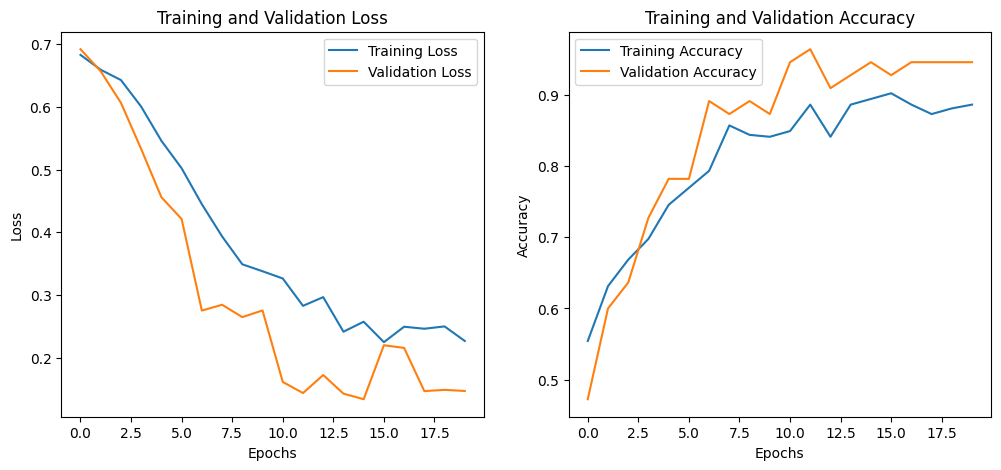

In [59]:
# trace les courbes de perte et de précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [60]:
# torch.save(model.state_dict(), '/kaggle/working/emotion_model.pth')

## **PREDICTIONS**

Test Loss: 0.1225
Test Accuracy: 0.9626


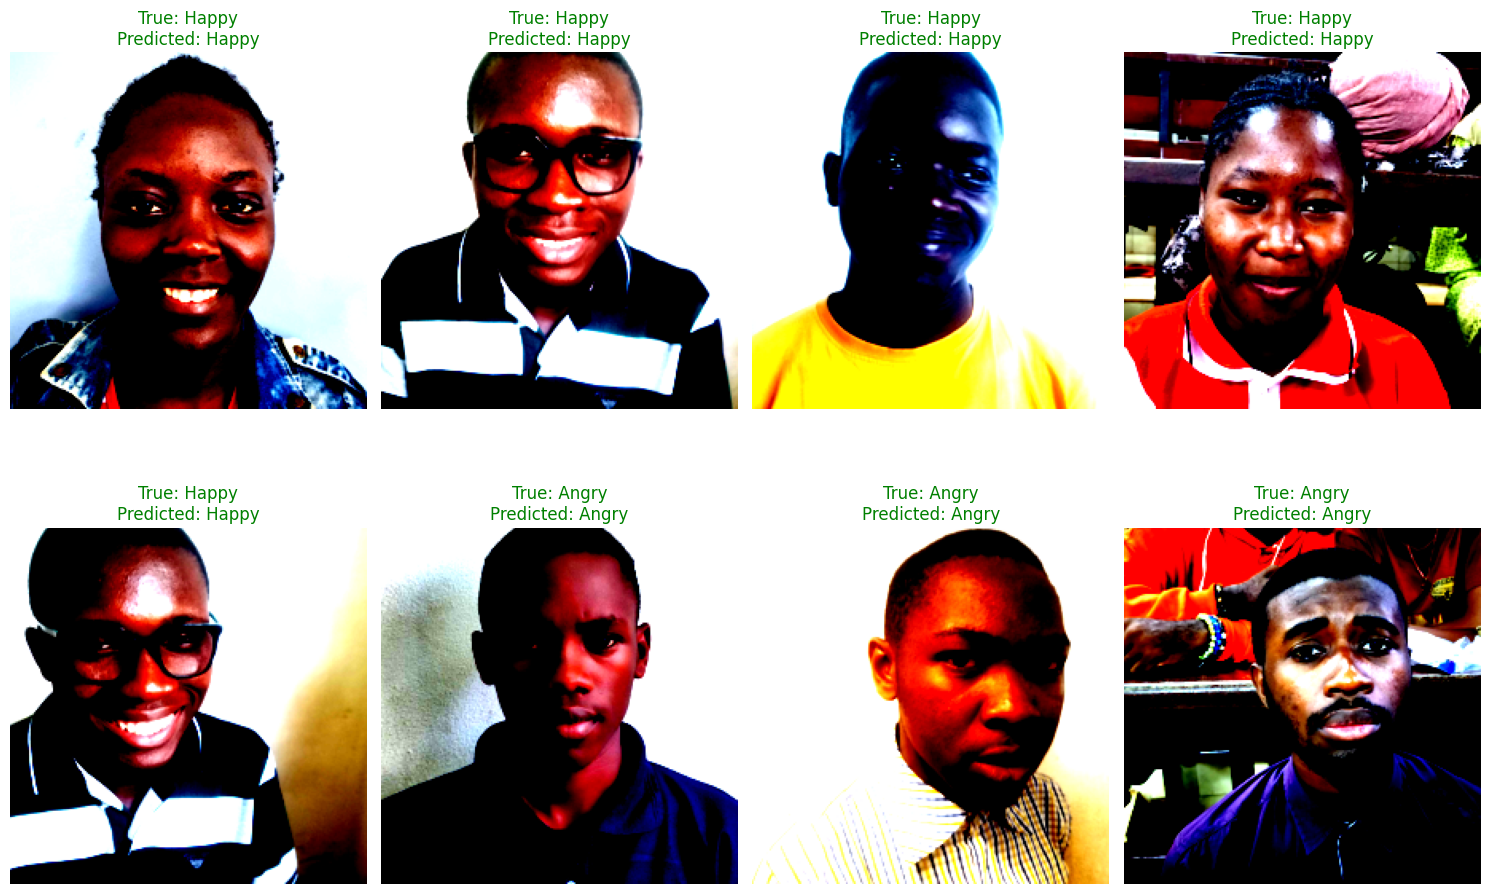

In [96]:
# charge le modèle EfficientNetB0 pré-entraîné
model = models.efficientnet_b0(pretrained=True)

# décongele les couches convolutives
for param in model.features.parameters():
    param.requires_grad = True

# modification de la dernière couche
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

# utilisation de l'activation sigmoïde pour la sortie binaire
model.classifier = nn.Sequential(
    model.classifier,
    nn.Sigmoid()
)

# Le dispositif
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# charge les poids du meilleur modèle en ignorant les erreurs de clé
checkpoint = torch.load('/kaggle/working/best_model_efficient.pth')
model.load_state_dict(checkpoint, strict=False)

# Transformation des images de test
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Chargement des données de test
test_dataset = datasets.ImageFolder('/kaggle/working/data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fonction pour prédire les résultats en lot
def predict_batch(data_loader, model, device, criterion):
    model.eval()
    all_images = []
    all_true_labels = []
    all_predicted_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).view(-1)
            predicted = (outputs > 0.5).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            all_images.extend(inputs.cpu())
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    return all_images, all_true_labels, all_predicted_labels, avg_loss

# Fonction de perte
criterion = nn.BCELoss()

# Les prédictions pour l'ensemble de test
images, true_labels, predicted_labels, avg_loss = predict_batch(test_loader, model, device, criterion)

# Calcul de la précision
correct_predictions = np.sum(np.array(true_labels) == np.array(predicted_labels))
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions
print(f'Test Loss: {avg_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# sélection aléatoire d'exemples pour chaque classe
happy_indices = [idx for idx, label in enumerate(true_labels) if label == 1]
angry_indices = [idx for idx, label in enumerate(true_labels) if label == 0]

# mélange aléatoirement les indices de chaque classe
np.random.shuffle(happy_indices)
np.random.shuffle(angry_indices)

# sélectionne 4 exemples de chaque classe
selected_indices = happy_indices[:5] + angry_indices[:5]
selected_images = [images[idx] for idx in selected_indices]
selected_true_labels = [true_labels[idx] for idx in selected_indices]
selected_predicted_labels = [predicted_labels[idx] for idx in selected_indices]

# affiche les images sélectionnées avec les étiquettes
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i].permute(1, 2, 0).cpu().numpy())
    true_label = 'Happy' if selected_true_labels[i] == 1 else 'Angry'
    predicted_label = 'Happy' if selected_predicted_labels[i] == 1 else 'Angry'

    text_color = 'green' if true_label == predicted_label else 'red'
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=12, color=text_color)
    ax.axis('off')

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()


# **MODELE VGG16**

## **Definition du modele**

In [64]:
# Chargement du modèle VGG16 pré-entraîné
model2 = models.vgg16(pretrained=True)

# on décongele les couches convolutives
for param in model2.features.parameters():
    param.requires_grad = True

# modifie la dernière couche
num_features = model2.classifier[6].in_features
model2.classifier[6] = nn.Linear(num_features, 1)

# activation sigmoïde pour la sortie binaire
model2.classifier = nn.Sequential(
    model2.classifier,
    nn.Sigmoid()
)

# fonction de perte et l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 160MB/s]  


## **Entrainement du modele**

In [65]:
# Entraînement du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

num_epochs = 20
patience = 5  # Nombre d'époques à attendre sans amélioration avant d'arrêter l'entraînement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Listes pour stocker les valeurs de perte et de précision pour chaque époque
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model2(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs - 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')

    model2.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model2(inputs).view(-1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct_val / total_val
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs - 1}, Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}')

    # Early Stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        epochs_without_improvement = 0
        # Sauvegarde le modèle
        torch.save(model2.state_dict(), 'best_model2.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

# # Charge le meilleur modèle sauvegardé
# model2.load_state_dict(torch.load('best_model2.pth'))


Epoch 0/19, Training Loss: 0.7250, Training Accuracy: 0.4562
Epoch 0/19, Validation Loss: 0.6912, Validation Accuracy: 0.5091
Epoch 1/19, Training Loss: 0.6899, Training Accuracy: 0.5119
Epoch 1/19, Validation Loss: 0.6712, Validation Accuracy: 0.5818
Epoch 2/19, Training Loss: 0.7057, Training Accuracy: 0.5491
Epoch 2/19, Validation Loss: 0.6900, Validation Accuracy: 0.4909
Epoch 3/19, Training Loss: 0.6826, Training Accuracy: 0.5729
Epoch 3/19, Validation Loss: 0.6836, Validation Accuracy: 0.4545
Epoch 4/19, Training Loss: 0.6784, Training Accuracy: 0.5597
Epoch 4/19, Validation Loss: 0.6100, Validation Accuracy: 0.7091
Epoch 5/19, Training Loss: 0.5998, Training Accuracy: 0.6790
Epoch 5/19, Validation Loss: 0.5077, Validation Accuracy: 0.7273
Epoch 6/19, Training Loss: 0.6274, Training Accuracy: 0.6711
Epoch 6/19, Validation Loss: 0.6362, Validation Accuracy: 0.5636
Epoch 7/19, Training Loss: 0.6322, Training Accuracy: 0.6313
Epoch 7/19, Validation Loss: 0.4931, Validation Accuracy:

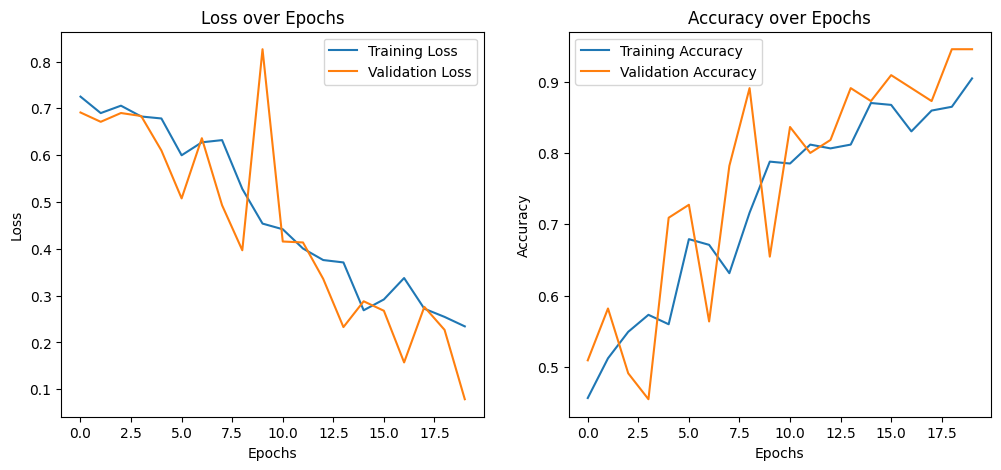

In [66]:
# trace les courbes de perte et de précision

plt.figure(figsize=(12, 5))

# Tracé de la perte
plt.subplot(1, 2, 1)
plt.plot( train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracé de la précision
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot( val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## **PREDICTIONS**

Test Loss: 0.1114
Test Accuracy: 0.9533


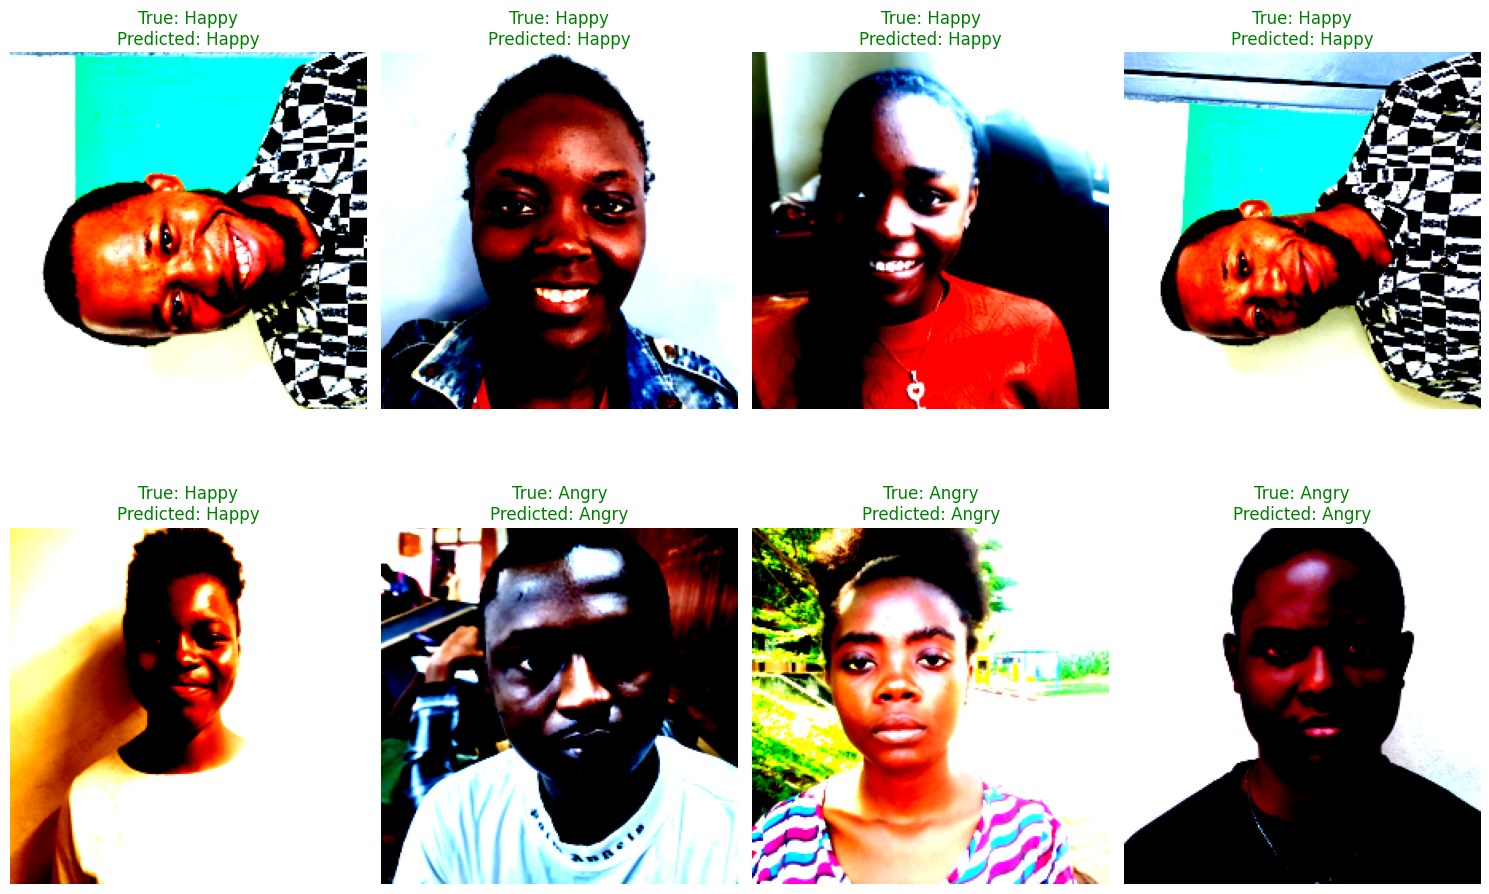

In [112]:
# charge le modèle VGG16 pré-entraîné
model2 = models.vgg16(pretrained=True)

# décongele les couches convolutives
for param in model2.features.parameters():
    param.requires_grad = True

# modification de la dernière couche
num_features = model2.classifier[6].in_features
model2.classifier[6] = nn.Linear(num_features, 1)

# utilisation de l'activation sigmoïde pour la sortie binaire
model2.classifier = nn.Sequential(
    model2.classifier,
    nn.Sigmoid()
)

# Le dispositif
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

# charge les poids du meilleur modèle en ignorant les erreurs de clé
checkpoint = torch.load('/kaggle/working/best_model2.pth')
model2.load_state_dict(checkpoint, strict=False)

# Transformation des images de test
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Chargement des données de test
test_dataset = datasets.ImageFolder('/kaggle/working/data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fonction pour prédire les résultats en lot
def predict_batch(data_loader, model2, device, criterion):
    model2.eval()
    all_images = []
    all_true_labels = []
    all_predicted_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model2(inputs).view(-1)
            predicted = (outputs > 0.5).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            all_images.extend(inputs.cpu())
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    return all_images, all_true_labels, all_predicted_labels, avg_loss

# Fonction de perte
criterion = nn.BCELoss()

# Les prédictions pour l'ensemble de test
images, true_labels, predicted_labels, avg_loss = predict_batch(test_loader, model2, device, criterion)

# Calcul de la précision
correct_predictions = np.sum(np.array(true_labels) == np.array(predicted_labels))
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions
print(f'Test Loss: {avg_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Sélection aléatoire d'exemples pour chaque classe
happy_indices = [idx for idx, label in enumerate(true_labels) if label == 1]
angry_indices = [idx for idx, label in enumerate(true_labels) if label == 0]

# melange aléatoirement les indices de chaque classe
np.random.shuffle(happy_indices)
np.random.shuffle(angry_indices)

# sélectionne 5 exemples de chaque classe
selected_indices = happy_indices[:5] + angry_indices[:5]
selected_images = [images[idx] for idx in selected_indices]
selected_true_labels = [true_labels[idx] for idx in selected_indices]
selected_predicted_labels = [predicted_labels[idx] for idx in selected_indices]

# affiche les images sélectionnées avec les étiquettes
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i].permute(1, 2, 0).cpu().numpy())
    true_label = 'Happy' if selected_true_labels[i] == 1 else 'Angry'
    predicted_label = 'Happy' if selected_predicted_labels[i] == 1 else 'Angry'

    text_color = 'green' if true_label == predicted_label else 'red'
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=12, color=text_color)
    ax.axis('off')

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()


# **MODELE RESNET**

## **Definition du modele**

In [67]:
# Chargement du modèle ResNet50 pré-entraîné
model3 = models.resnet50(pretrained=True)

# on décongele les couches convolutives
for param in model3.parameters():
    param.requires_grad = True

# modifie la dernière couche
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, 1)

# activation sigmoïde pour la sortie binaire
model3 = nn.Sequential(
    model3,
    nn.Sigmoid()
)

#fonction de perte et l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


## **Entrainement du modele**

In [68]:
# Entraînement du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3.to(device)

num_epochs = 20
patience = 5  # Nombre d'époques à attendre sans amélioration avant d'arrêter l'entraînement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Listes pour stocker les valeurs de perte et de précision pour chaque époque
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model3(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs - 1}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')

    model3.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model3(inputs).view(-1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct_val / total_val
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs - 1}, Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}')

    # Early Stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        epochs_without_improvement = 0
        # Sauvegarder le modèle
        torch.save(model3.state_dict(), 'best_model3.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break



Epoch 0/19, Training Loss: 0.6883, Training Accuracy: 0.5358
Epoch 0/19, Validation Loss: 0.6513, Validation Accuracy: 0.4727
Epoch 1/19, Training Loss: 0.5427, Training Accuracy: 0.7188
Epoch 1/19, Validation Loss: 0.3472, Validation Accuracy: 0.8545
Epoch 2/19, Training Loss: 0.4136, Training Accuracy: 0.7878
Epoch 2/19, Validation Loss: 0.3502, Validation Accuracy: 0.8000
Epoch 3/19, Training Loss: 0.3413, Training Accuracy: 0.8382
Epoch 3/19, Validation Loss: 1.0629, Validation Accuracy: 0.6182
Epoch 4/19, Training Loss: 0.3646, Training Accuracy: 0.8196
Epoch 4/19, Validation Loss: 0.4381, Validation Accuracy: 0.8545
Epoch 5/19, Training Loss: 0.3088, Training Accuracy: 0.8435
Epoch 5/19, Validation Loss: 0.1831, Validation Accuracy: 0.9455
Epoch 6/19, Training Loss: 0.2810, Training Accuracy: 0.8833
Epoch 6/19, Validation Loss: 0.1498, Validation Accuracy: 0.9455
Epoch 7/19, Training Loss: 0.3472, Training Accuracy: 0.8196
Epoch 7/19, Validation Loss: 0.2959, Validation Accuracy:

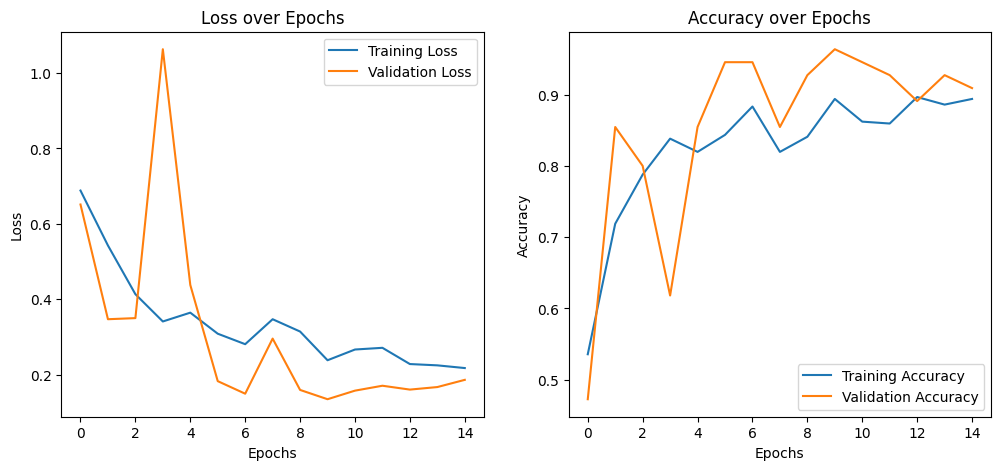

In [69]:

# trace les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Tracé de la perte
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracé de la précision
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## **PREDICTIONS**

Test Loss: 0.1833
Test Accuracy: 0.9065


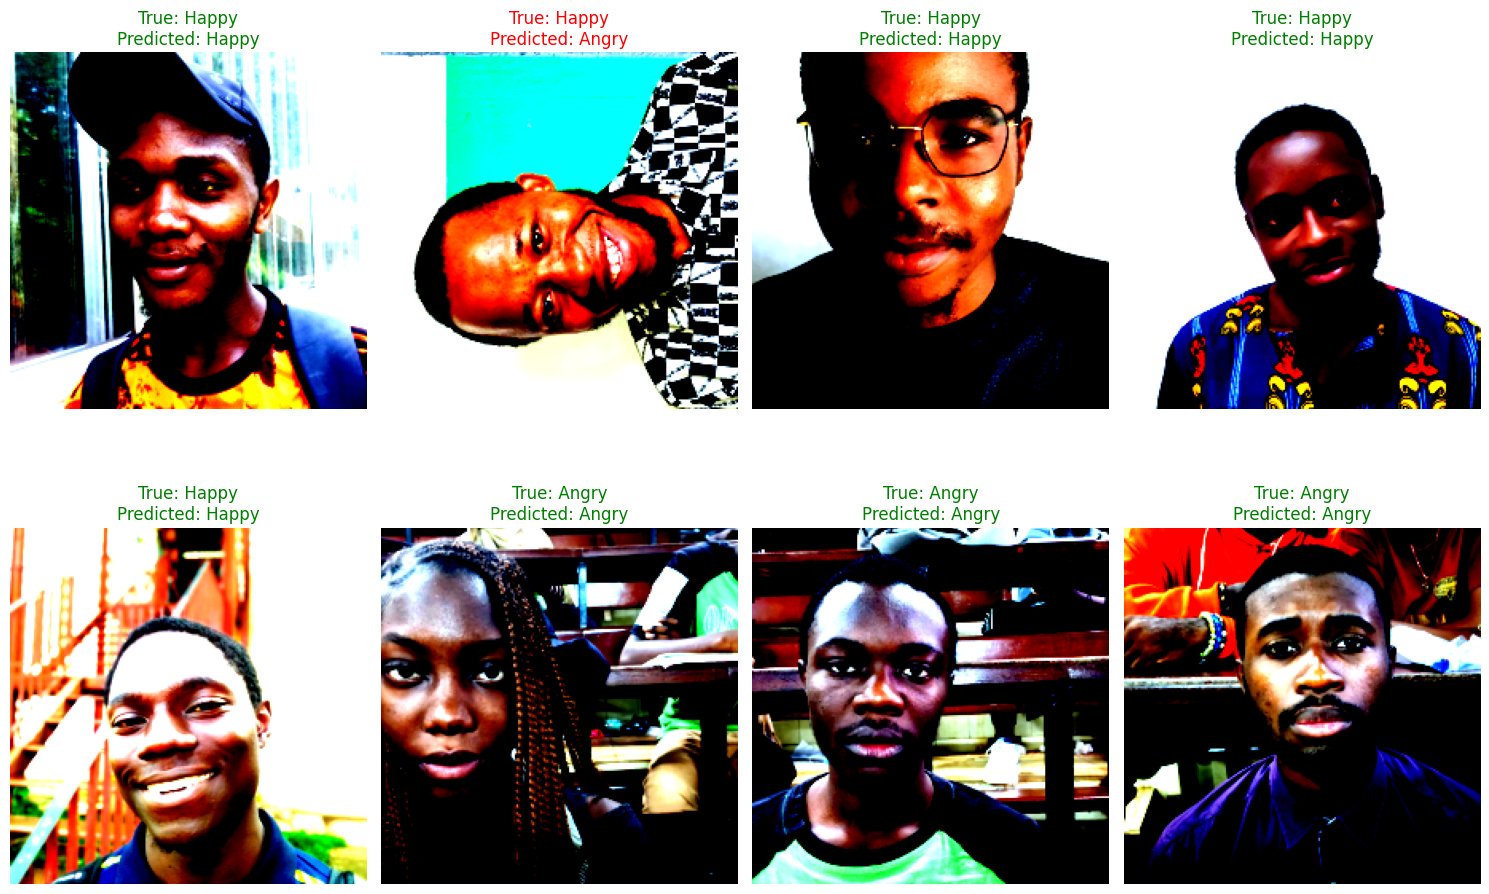

In [117]:
# charge le modèle ResNet pré-entraîné
model3 = models.resnet50(pretrained=True)

# décongele les couches convolutives
for param in model3.parameters():
    param.requires_grad = True

# modification de la dernière couche
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, 1)

# utilisation de l'activation sigmoïde pour la sortie binaire
model3 = nn.Sequential(
    model3,
    nn.Sigmoid()
)

# Le dispositif
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3.to(device)

# charge les poids du meilleur modèle 
checkpoint = torch.load('/kaggle/working/best_model3.pth')
model3.load_state_dict(checkpoint, strict=False)

# Transformation des images de test
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Chargement des données de test
test_dataset = datasets.ImageFolder('/kaggle/working/data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fonction pour prédire les résultats en lot
def predict_batch(data_loader, model3, device, criterion):
    model3.eval()
    all_images = []
    all_true_labels = []
    all_predicted_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model3(inputs).view(-1)
            predicted = (outputs > 0.5).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            all_images.extend(inputs.cpu())
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    return all_images, all_true_labels, all_predicted_labels, avg_loss

# Fonction de perte
criterion = nn.BCELoss()

# Les prédictions pour l'ensemble de test
images, true_labels, predicted_labels, avg_loss = predict_batch(test_loader, model3, device, criterion)

# Calcul de la précision
correct_predictions = np.sum(np.array(true_labels) == np.array(predicted_labels))
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions
print(f'Test Loss: {avg_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Sélection aléatoire d'exemples pour chaque classe
happy_indices = [idx for idx, label in enumerate(true_labels) if label == 1]
angry_indices = [idx for idx, label in enumerate(true_labels) if label == 0]

# melange aléatoirement les indices de chaque classe
np.random.shuffle(happy_indices)
np.random.shuffle(angry_indices)

# sélectionner 5 exemples de chaque classe
selected_indices = happy_indices[:5] + angry_indices[:5]
selected_images = [images[idx] for idx in selected_indices]
selected_true_labels = [true_labels[idx] for idx in selected_indices]
selected_predicted_labels = [predicted_labels[idx] for idx in selected_indices]

# affiche les images sélectionnées avec les étiquettes
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i].permute(1, 2, 0).cpu().numpy())
    true_label = 'Happy' if selected_true_labels[i] == 1 else 'Angry'
    predicted_label = 'Happy' if selected_predicted_labels[i] == 1 else 'Angry'

    text_color = 'green' if true_label == predicted_label else 'red'
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=12, color=text_color)
    ax.axis('off')

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()


# **MODELE EFFICIENTNET+SVM**

## **Definition du modele**

In [119]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np


## **Entrainement du modele**

In [125]:
import torch.optim as optim

# charge le modèle EfficientNetB0 pré-entraîné
model4 = models.efficientnet_b0(pretrained=True)

# décongele les couches convolutives
for param in model4.features.parameters():
    param.requires_grad = True

# Supprime la dernière couche de classification
model4.classifier = nn.Identity()

# Dispositif
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4.to(device)

# Optimiseur et critère de perte
optimizer = optim.Adam(model4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Fonction pour entraîner EfficientNetB0 et extraire les caractéristiques
def train_and_extract_features(model4, train_loader, val_loader, optimizer, criterion, device, num_epochs=20):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model4.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model4(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Validation
        model4.eval()
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model4(inputs)
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        val_accuracy = correct_predictions / total_predictions
        print(f'Validation Accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model4.state_dict(), 'best_model4.pth')

    # Extraction des caractéristiques
    train_features, train_labels = extract_features(train_loader, model4, device)
    val_features, val_labels = extract_features(val_loader, model4, device)

    return train_features, train_labels, val_features, val_labels

# entraîne EfficientNetB0 et extrait les caractéristiques
train_features, train_labels, val_features, val_labels = train_and_extract_features(
    model4, train_loader, val_loader, optimizer, criterion, device, num_epochs=20
)

# standardise les caractéristiques et entraîner le SVM
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

svm.fit(train_features, train_labels)

# prédiction des étiquettes de l'ensemble de validation
val_predictions = svm.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Final Validation Accuracy after SVM: {val_accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 6.8080
Validation Accuracy: 0.7273
Epoch [2/20], Loss: 6.4033
Validation Accuracy: 0.8000
Epoch [3/20], Loss: 6.2722
Validation Accuracy: 0.8000
Epoch [4/20], Loss: 6.1247
Validation Accuracy: 0.8182
Epoch [5/20], Loss: 6.0118
Validation Accuracy: 0.8909
Epoch [6/20], Loss: 5.9611
Validation Accuracy: 0.8364
Epoch [7/20], Loss: 5.8833
Validation Accuracy: 0.7636
Epoch [8/20], Loss: 5.8802
Validation Accuracy: 0.7636
Epoch [9/20], Loss: 5.8379
Validation Accuracy: 0.9273
Epoch [10/20], Loss: 5.8129
Validation Accuracy: 0.7273
Epoch [11/20], Loss: 5.7487
Validation Accuracy: 0.6182
Epoch [12/20], Loss: 5.8643
Validation Accuracy: 0.6545
Epoch [13/20], Loss: 5.8580
Validation Accuracy: 0.8545
Epoch [14/20], Loss: 5.8203
Validation Accuracy: 0.8182
Epoch [15/20], Loss: 5.6903
Validation Accuracy: 0.5818
Epoch [16/20], Loss: 5.8929
Validation Accuracy: 0.7636
Epoch [17/20], Loss: 5.7977
Validation Accuracy: 0.7636
Epoch [18/20], Loss: 5.7679
Validation Accuracy: 0.7818
E

## **PREDICTIONS**

Test Accuracy after SVM: 0.8505


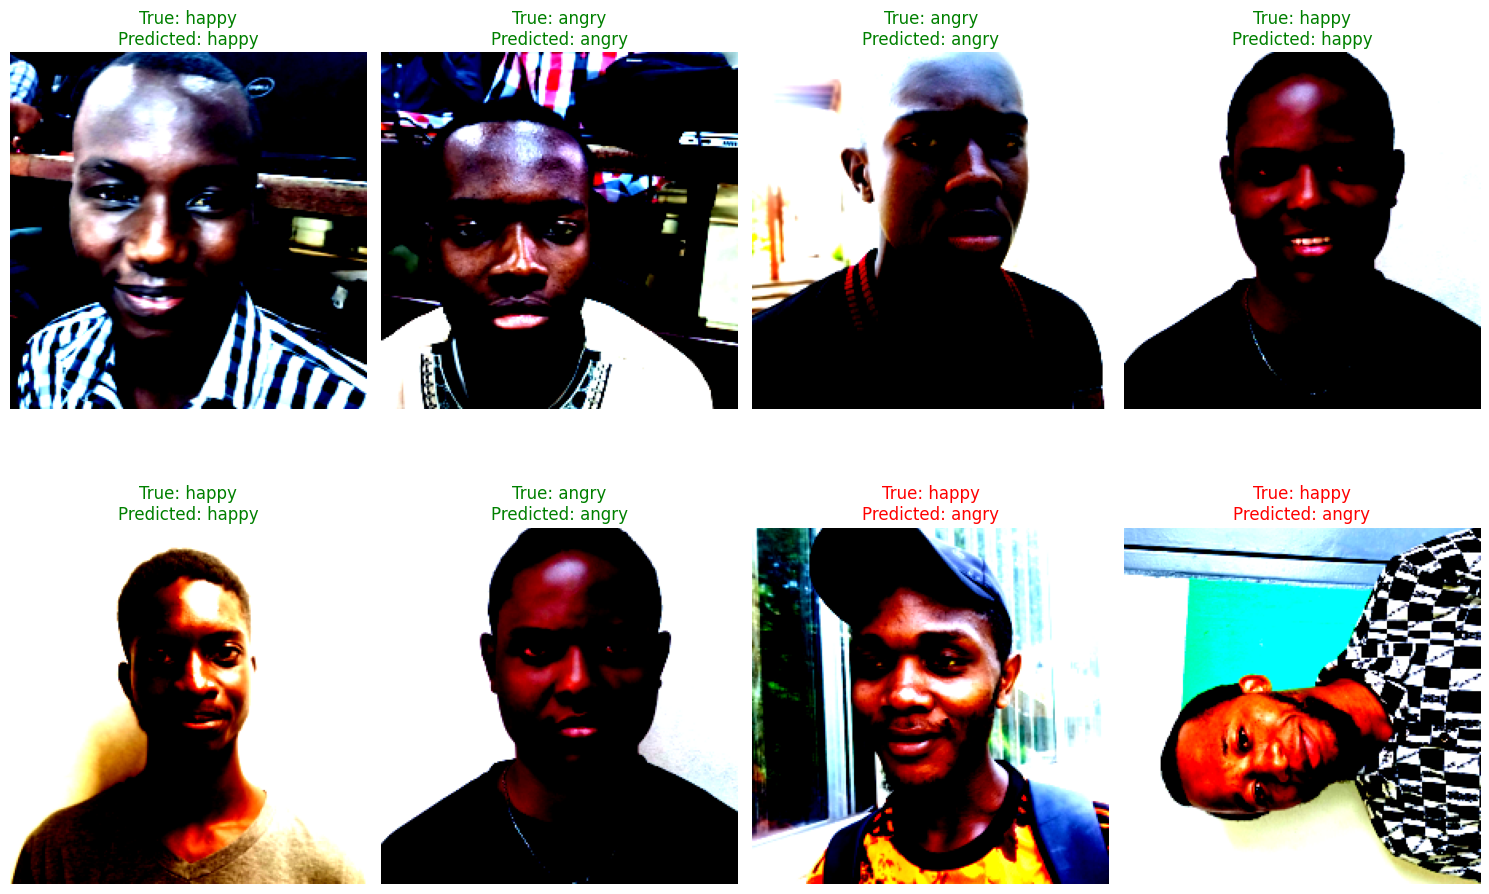

In [133]:
# charge le modèle EfficientNetB0 pré-entraîné
model4 = models.efficientnet_b0(pretrained=True)

# décongele les couches convolutives
for param in model4.features.parameters():
    param.requires_grad = True

# supprime la dernière couche de classification
model4.classifier = nn.Identity()

# Dispositif
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4.to(device)

# Optimiseur et critère de perte (peut être différent de l'entraînement précédent si besoin)
optimizer = optim.Adam(model4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# charge les poids du meilleur modèle d'EfficientNetB0
model4.load_state_dict(torch.load('best_model4.pth'))

# Transformation des images de test
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Chargement des données de test
test_dataset = datasets.ImageFolder('/kaggle/working/data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fonction pour extraire les caractéristiques des ensembles d'entraînement et de test
def extract_features(loader, model, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extraction des caractéristiques des ensembles d'entraînement et de test
train_features, train_labels = extract_features(train_loader, model4, device)
test_features, test_labels = extract_features(test_loader, model4, device)

# standardise les caractéristiques et entraîner le SVM
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm.fit(train_features, train_labels)

# Prédiction des étiquettes de l'ensemble de test
test_predictions = svm.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy after SVM: {test_accuracy:.4f}')

# affichage des résultats sur un échantillon d'images de test
num_samples = 8 
selected_indices = np.random.choice(len(test_dataset), num_samples, replace=False)
selected_images = [test_dataset[idx][0] for idx in selected_indices]
selected_true_labels = [test_dataset.classes[test_dataset[idx][1]] for idx in selected_indices]
selected_predicted_labels = [test_dataset.classes[test_predictions[idx]] for idx in selected_indices]

# affichage des images sélectionnées avec les étiquettes
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image = selected_images[i].permute(1, 2, 0).numpy()
    ax.imshow(image)
    true_label = selected_true_labels[i]
    predicted_label = selected_predicted_labels[i]

    text_color = 'green' if true_label == predicted_label else 'red'
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=12, color=text_color)
    ax.axis('off')

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()
